# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

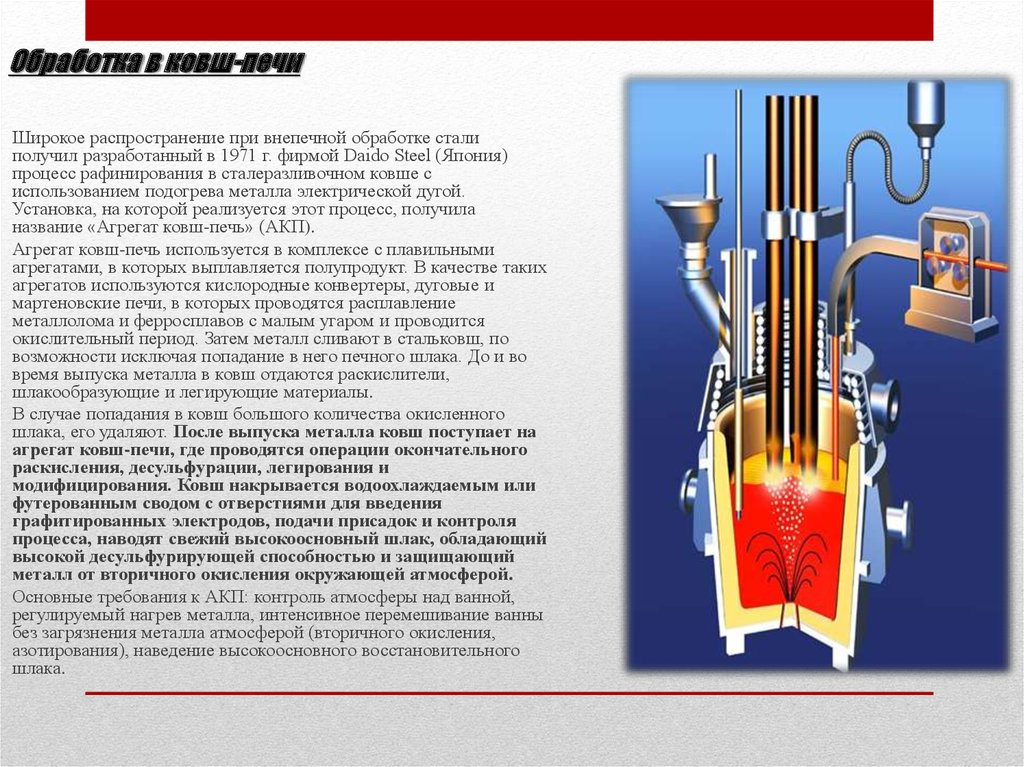

In [1]:
# Импортируем необходимые библиотеки

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
RANDOM_STATE = 190623
cv_counts = 5

## Исследовательский анализ данных

In [3]:
# Прочитаем данные

try:
    #данные об электродах
    data_arc = pd.read_csv('D:\studies/data_arc.csv')
    
    #данные о подаче сыпучих материалов (объём)
    data_bulk = pd.read_csv('D:\studies/data_bulk.csv')

    #данные о подаче сыпучих материалов (время)
    data_bulk_time = pd.read_csv('D:\studies/data_bulk_time.csv') 

    #данные о продувке сплава газом
    data_gas = pd.read_csv('D:\studies/data_gas.csv')

    #результаты измерения температуры
    data_temp = pd.read_csv('D:\studies/data_temp.csv')

    #данные о проволочных материалах (объём)
    data_wire = pd.read_csv('D:\studies/data_wire.csv')

    #данные о проволочных материалах (время)
    data_wire_time = pd.read_csv('D:\studies/data_wire_time.csv')

except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

### Исследуем данные об электродах

In [4]:
display(data_arc.head(10))

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [5]:
# Приведем названия столбцов в соответствии со стандартами PEP8

data_arc.columns = ['key', 'start_heating', 'end_heating', 'active_power', 'reactive_power']

In [6]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   start_heating   14876 non-null  object 
 2   end_heating     14876 non-null  object 
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


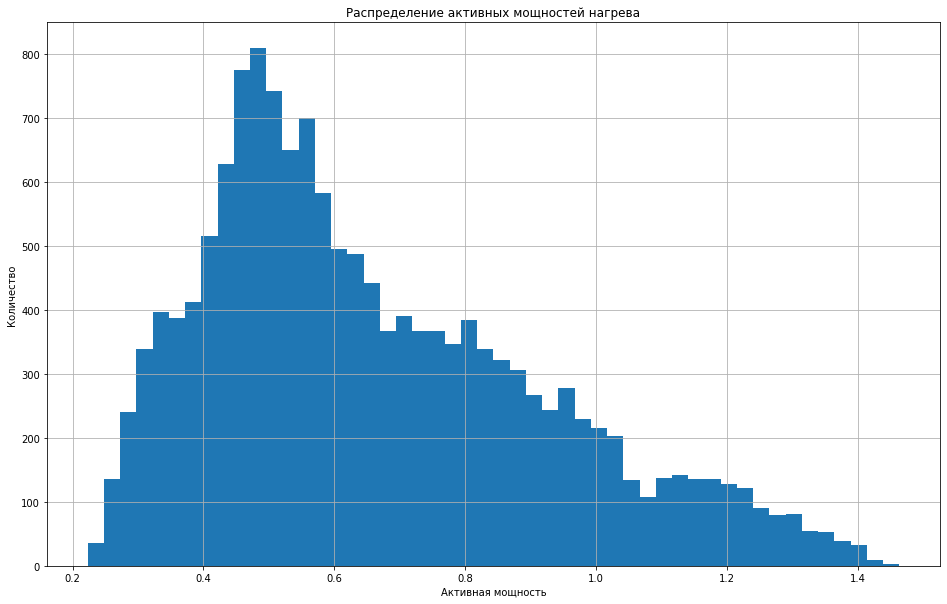

In [7]:
plt.figure()
ax = data_arc['active_power'].hist(bins=50, figsize=(16,10))
ax.set_title('Распределение активных мощностей нагрева')
ax.set_ylabel('Количество')
ax.set_xlabel('Активная мощность')
plt.show()

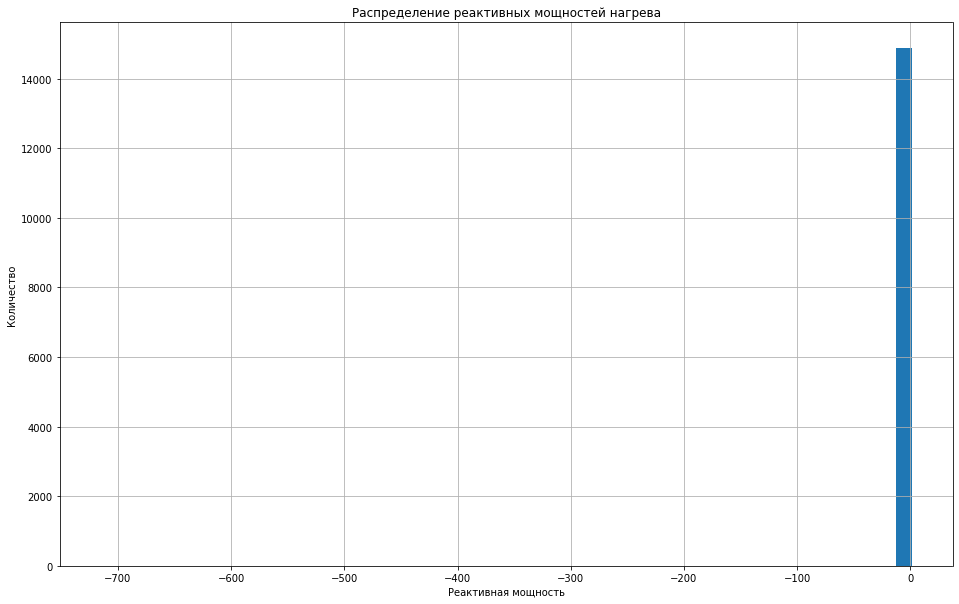

In [8]:
plt.figure()
ax = data_arc['reactive_power'].hist(bins=50, figsize=(16,10))
ax.set_title('Распределение реактивных мощностей нагрева')
ax.set_ylabel('Количество')
ax.set_xlabel('Реактивная мощность')
plt.show()

В распределении реактивной мощности есть какой-то странный выброс. Проверим это

In [9]:
data_arc.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [10]:
# Посмотрим на топ 5 реактивной мощности
data_arc.sort_values(by = ['reactive_power']).head()

,key,start_heating,end_heating,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
709,152,2019-05-09 11:26:58,2019-05-09 11:29:41,0.228852,0.153777
3290,711,2019-05-31 07:16:01,2019-05-31 07:20:05,0.242989,0.153921
11794,2567,2019-08-13 05:51:16,2019-08-13 05:52:22,0.288314,0.155221
6130,1336,2019-06-22 15:46:26,2019-06-22 15:47:50,0.244191,0.156525


Действительно единичный выброс. Посмотрим, какие итерации нагрева были в этой партии.

In [11]:
data_arc[data_arc['key'] == 2116]

,key,start_heating,end_heating,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


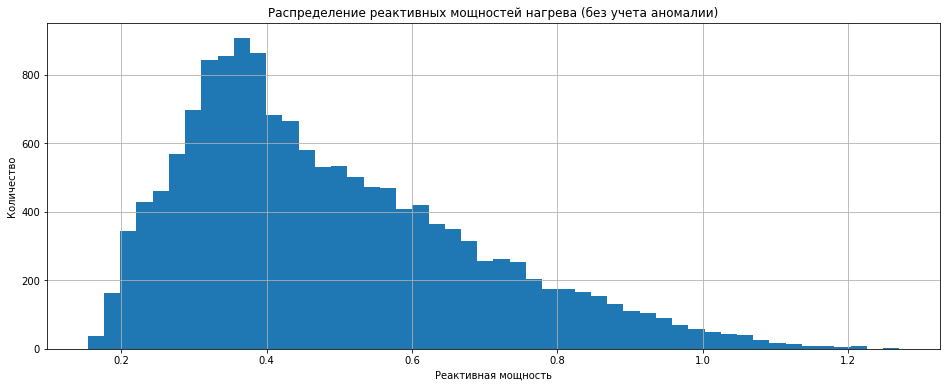

In [12]:
# Попробуем удалить выброс и посмотреть на распределение реактивной мощности без аномалии

plt.figure()
ax = data_arc[data_arc['reactive_power'] > 0]['reactive_power'].hist(bins=50, figsize=(16,6))
ax.set_title('Распределение реактивных мощностей нагрева (без учета аномалии)')
ax.set_ylabel('Количество')
ax.set_xlabel('Реактивная мощность')
plt.show()

В данных нет пропусков, однако необходимо исправить тип данных на datetime. Распределение мощностей носит нормальный характер, однако имеется непонятный выброс отрицательной реактивной мощности.

### Исследуем данные о подаче сыпучих материалов (объём)

In [13]:
display(data_bulk.head(10))

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [14]:
# Приведем названия столбцов в соответствии со стандартами PEP8

data_bulk.rename(columns=lambda x: x.replace('Bulk ', 'bulk_'), inplace=True)

In [15]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [16]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


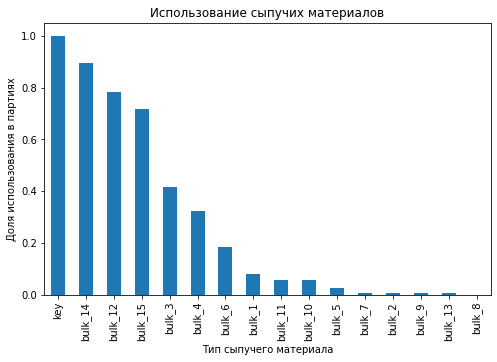

In [17]:
# Посмотрим, если ли сыпущие материалы, которые использовались в производстве партий очень редко:

plt.figure(figsize = (8,5))
ax = (~data_bulk.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar')
ax.set_title('Использование сыпучих материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип сыпучего материала')
plt.show()

Подача сыпучих материалов осуществляется неравномерно, видимо, в зависимости от состава исходного сырья. Пропуски в данных образовались в связи с тем, что соответствующий элемент не добавлялся в процессе. Необходимо уточнить у заказчика важность каждой составляющей.

### Исследуем данные о подаче сыпучих материалов (время)

In [18]:
display(data_bulk_time.head(10))

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


In [19]:
# Приведем названия столбцов в соответствии со стандартами PEP8

data_bulk_time.rename(columns=lambda x: x.replace('Bulk ', 'bulk_time_'), inplace=True)

In [20]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           3129 non-null   int64 
 1   bulk_time_1   252 non-null    object
 2   bulk_time_2   22 non-null     object
 3   bulk_time_3   1298 non-null   object
 4   bulk_time_4   1014 non-null   object
 5   bulk_time_5   77 non-null     object
 6   bulk_time_6   576 non-null    object
 7   bulk_time_7   25 non-null     object
 8   bulk_time_8   1 non-null      object
 9   bulk_time_9   19 non-null     object
 10  bulk_time_10  176 non-null    object
 11  bulk_time_11  177 non-null    object
 12  bulk_time_12  2450 non-null   object
 13  bulk_time_13  18 non-null     object
 14  bulk_time_14  2806 non-null   object
 15  bulk_time_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Необходимо привести данные к формату datetime

### Исследуем данные о продувке сплава газом

In [21]:
display(data_gas.head(10))

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [22]:
# Приведем названия столбцов в соответствии со стандартами PEP8

data_gas.columns = ['key', 'gaz_1']

In [23]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gaz_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [24]:
data_gas.describe()

,key,gaz_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [25]:
display(data_gas.duplicated().sum())

0

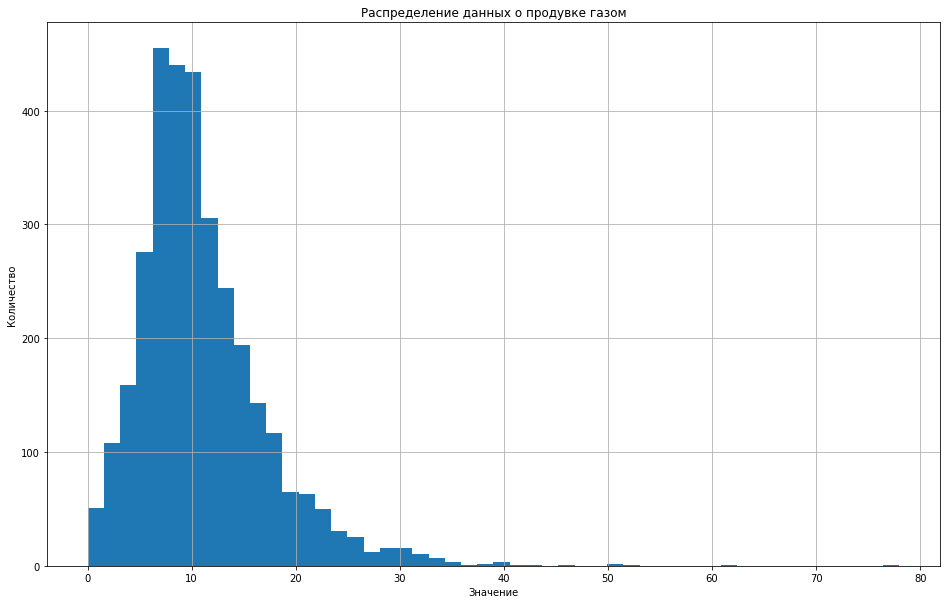

In [26]:
plt.figure()
ax = data_gas['gaz_1'].hist(bins=50, figsize=(16,10))
ax.set_title('Распределение данных о продувке газом')
ax.set_ylabel('Количество')
ax.set_xlabel('Значение')
plt.show()

Пропусков нет, распределение нормальное. 

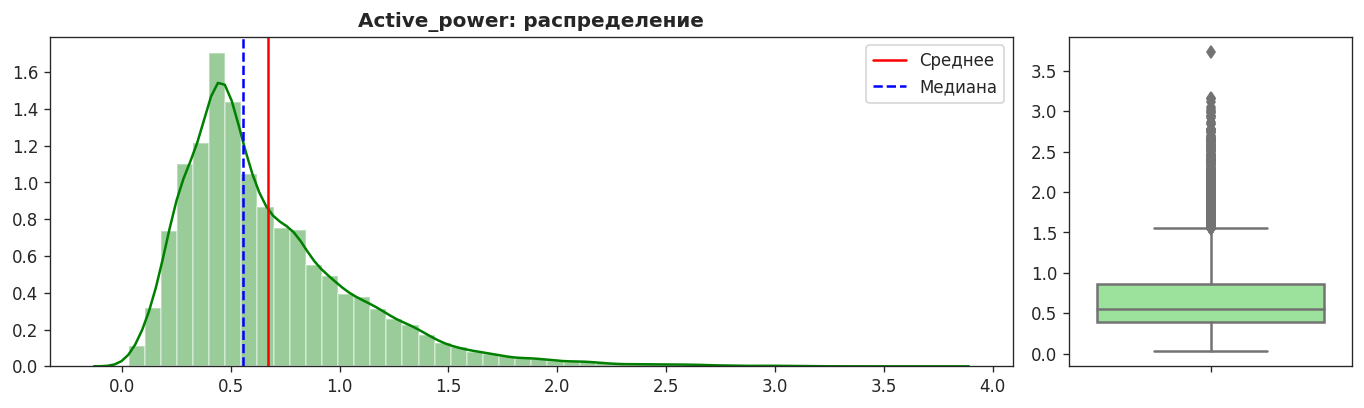

#### Исследуем результаты измерения температуры

In [27]:
display(data_temp.head(10))

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [28]:
# Приведем названия столбцов в соответствии со стандартами PEP8

data_temp.columns = ['key', 'measuring_time', 'temp']

In [29]:
data_temp.describe()

,key,temp
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [30]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             18092 non-null  int64  
 1   measuring_time  18092 non-null  object 
 2   temp            14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


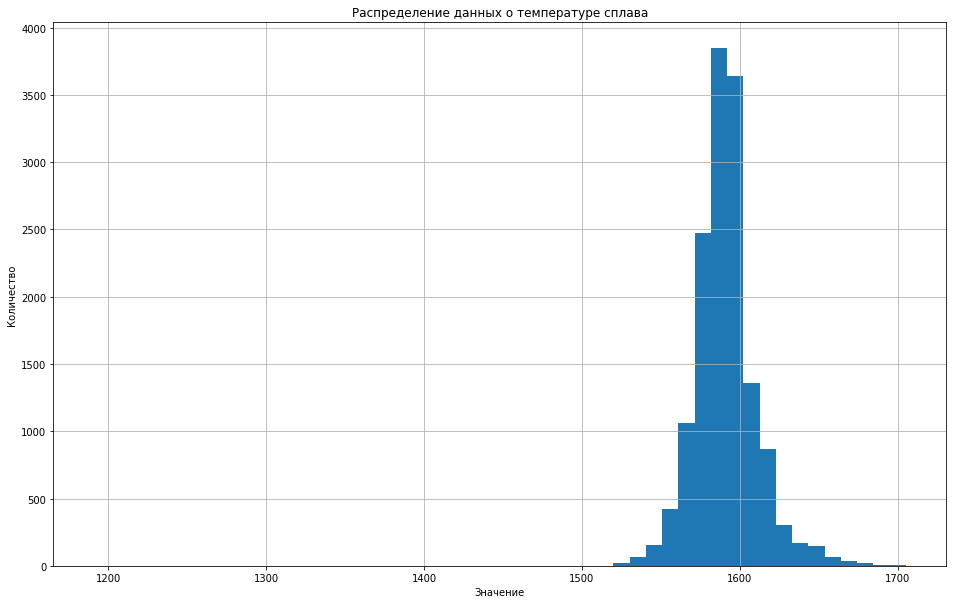

In [31]:
plt.figure()
ax = data_temp['temp'].hist(bins=50, figsize=(16,10))
ax.set_title('Распределение данных о температуре сплава')
ax.set_ylabel('Количество')
ax.set_xlabel('Значение')
plt.show()

Температура варьируется от 1191 градусов до 1705 градусов. Видимо, зависит от марки сплава, который выплавляется в конкретной партии. На первый взгляд аномалий не видно. Однако необходимо уточнить у заказчика допустимый диапазон температур. Необходимо привести столбец measuring_time к формату datetime.

### Исследуем данные о проволочных материалах (объём)

In [32]:
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Приведем названия столбцов в соответствии со стандартами PEP8

data_wire.rename(columns=lambda x: x.replace('Wire ', 'wire_'), inplace=True)

In [34]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [35]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


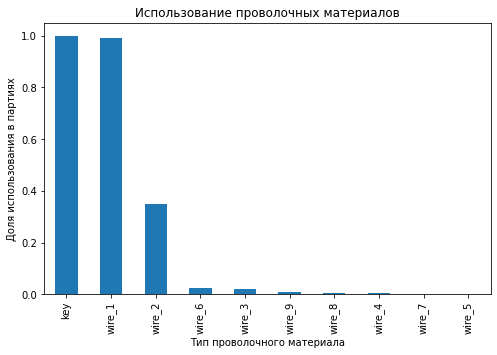

In [36]:
# Посмотрим, если ли проволочные материалы, которые использовались в производстве партий очень редко:

plt.figure(figsize = (8,5))
ax = (~data_wire.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar')
ax.set_title('Использование проволочных материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип проволочного материала')
plt.show()

Подача проволочных материалов осуществляется неравномерно, видимо, в зависимости от состава исходного сырья. Пропуски в данных образовались в связи с тем, что соответствующий элемент не добавлялся в процессе. Необходимо уточнить у заказчика важность каждой составляющей.

### Исследуем данные о проволочных материалах (время)

In [37]:
data_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# Приведем названия столбцов в соответствии со стандартами PEP8

data_wire_time.rename(columns=lambda x: x.replace('Wire ', 'wire_time_'), inplace=True)

In [39]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   key          3081 non-null   int64 
 1   wire_time_1  3055 non-null   object
 2   wire_time_2  1079 non-null   object
 3   wire_time_3  63 non-null     object
 4   wire_time_4  14 non-null     object
 5   wire_time_5  1 non-null      object
 6   wire_time_6  73 non-null     object
 7   wire_time_7  11 non-null     object
 8   wire_time_8  19 non-null     object
 9   wire_time_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Необходимо привести данные к формату datetime

### Посмотрим количество итераций для различных партий 

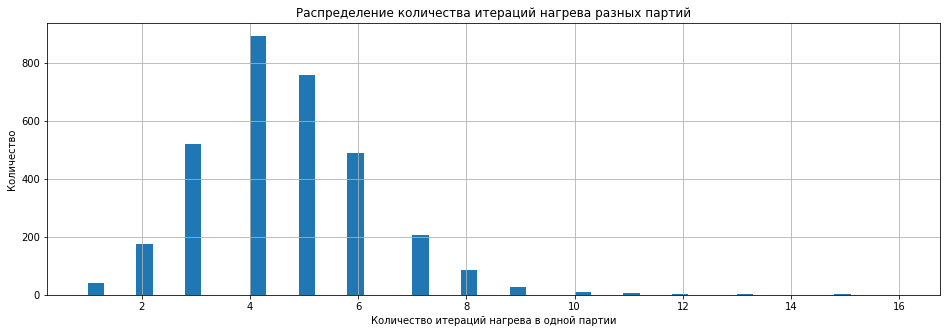

In [40]:
plt.figure()
ax = data_arc.groupby('key')['active_power'].count().hist(bins=50, figsize=(16,5))
ax.set_title('Распределение количества итераций нагрева разных партий')
ax.set_ylabel('Количество')
ax.set_xlabel('Количество итераций нагрева в одной партии')
plt.show()

Общий вывод по этапу.
1. Загрузили и проанализировали данные. В данных есть пропуски и аномальные значения. Выяснили последовательность действий при обработке стали в ковше. 
2. План проведения исследования:
    + Провести предобработку данных: изменить типы данных; обработать пропущенные и аномальные данные с учетом пожеланий заказчика.
    + Подготовить данные для обучения моделей. Составить сводную таблицу для обучения моделей; удалить неважные признаки.
    + Обучить регрессионные модели.
    + Оценить эффективность выбранных моделей на тестовой выборке.
    + Проанализировать важность факторов у модели-победителя.
    + Сделать общий вывод по всему проекту.


3. Вопросы к заказчику:
    + Имеется одна запись отрицательной реактивной мощности. Судя по всему, это ошибка приборов. Возможно ли восстановить значение реактивной мощности в одной итерации нагрева по косвенным данным или это значение необходимо удалить? Насколько важна одна итерация в общем цикле производства партии стали?
    + В процессе некоторые виды сыпучих и проволочных материалов используются в менее чем 10% случаев. Критично ли использование таких признаков для обучения моделей или эти добавки не важны и их можно игнорировать?
    + Важность такого признака, как продувка газом.
    + Почему такой разброс в температурах, с чем это связано?
    + Важность предсказания температуры для бизнес-процесса в общем и для целей энергосбережения в частности.

## Предобработка данных

По результатам встречи с заказчиком определились с планом предобработки данных.
1. Целевым признаком является конечная температура.
2. Важнейшими признаками будем считать:
+ начальная температура расплава
+ общая потраченная мощность на нагрев
+ количество присадок

### Предобработка данных о температуре

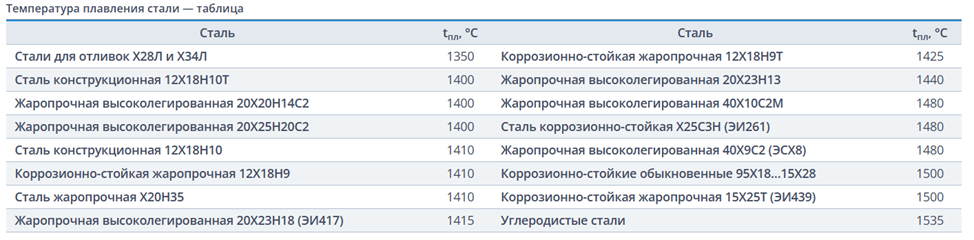

Исходя из вышеуказанной таблицы, минимальная температура плавления стали - 1350 градусов. Заказчик не уточнил марку стали, поэтому оставим нижнюю границу температуры в 1350 градусов.

In [41]:
# Выясним партии со значениями температуры ниже 1350 градусов

data_temp[data_temp['temp'] < 1350]

# Удалим аномалии далее при обработке мощностей

,key,measuring_time,temp
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [42]:
# Удалим пропуски в таблице data_temp
data_temp = data_temp.dropna(subset=['temp']).reset_index(drop=True)
data_temp = data_temp.sort_values(by=['measuring_time'])

In [43]:
# Удалим данные, где только один замер температуры
count = data_temp.groupby(by = 'key', as_index=False).count()
one = count[count['measuring_time']== 1]['key'].tolist()
data_temp = data_temp.query('key not in @one')

In [44]:
#сгруппируем по первым и последним значениям
data_temp = data_temp.groupby(by ='key').agg(['first', 'last']).reset_index()
data_temp.columns = data_temp.columns.droplevel()
data_temp.columns = ['key', 'measuring_time_start', 'measuring_time_end','temp_start','temp_end']
data_temp = data_temp[['key','temp_start','temp_end']]

### Предобработка данных об электродах

In [45]:
# Убираем явную аномалию в столбце реактивной мощности
# Убираем аномальные температуры расплава
# Убираем всю партию во всех данных. 
key = [867, 1214, 1619, 2052, 2116, 2561]# Партии с аномальными значениями
for key in key:
    data_arc = data_arc[data_arc['key'] != key]
    data_bulk = data_bulk[data_bulk['key'] != key]
    data_bulk_time = data_bulk_time[data_bulk_time['key'] != key]
    data_gas =  data_gas[data_gas['key'] != key]
    data_temp = data_temp[data_temp['key'] != key]
    data_wire = data_wire[data_wire['key'] != key]
    data_wire_time = data_wire_time[data_wire_time['key'] != key]


In [46]:
# Определим количество итераций нагрева
data_arc_count = data_arc.groupby(by = 'key', as_index = False).count()[['key','start_heating']]
data_arc_count.columns = ['key','count_of_heating_iterations']

In [47]:
# Исправляем тип данных
data_arc['start_heating'] = pd.to_datetime(data_arc['start_heating'], format='%Y-%m-%dT%H:%M:%S')
data_arc['end_heating'] = pd.to_datetime(data_arc['end_heating'], format='%Y-%m-%dT%H:%M:%S')

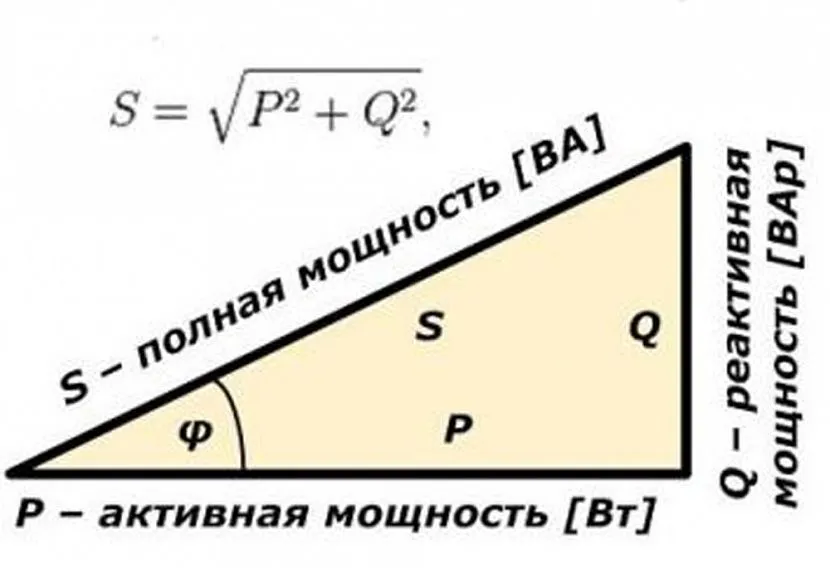

In [48]:
# Создаем дополнительные признаки:
# время нагрева 
# полная мощность
data_arc['total_time_heating'] = (data_arc['end_heating'] - data_arc['start_heating']) // pd.Timedelta('1s')
data_arc['total_power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)

In [49]:
# Вычисляем затраты энергии для каждой партии стали
data_arc['energy'] = data_arc['total_time_heating'] * data_arc['total_power']

In [50]:
# Поскольку прочие признаки были вычислительными для мощности, оставляем в data_arc только признак energy
data_arc = data_arc.groupby('key').agg({'energy': sum})

### Преобразуем данные о подаче  материалов

In [51]:
# Т.к. пропуск обозначает, что данный элемент не добавляли
# заменяем пропуски на 0
data_bulk = data_bulk.fillna(0)

# # Исправляем тип данных
# cols = data_bulk_time.columns[1:16]
# data_bulk_time[cols] = data_bulk_time[cols].apply(pd.to_datetime, format='%Y-%m-%dT%H:%M:%S')

In [52]:
# Аналогично поступаем с данными по подаче проволочных материалов
data_wire = data_wire.fillna(0)

# # Исправляем тип данных
# cols = data_wire_time.columns[1:16]
# data_wire_time[cols] = data_wire_time[cols].apply(pd.to_datetime, format='%Y-%m-%dT%H:%M:%S')

Удалять пропущенные во всей строке/столбце значения считаю нецелесообразным, т.к. в реальной ситуации могут добавляться все элементы, и это нужно учитывать. Данные о времени добавления присадок нам не нужны, т.к. не влияют на целевой признак. 

In [53]:
# Сгруппируем добавки по партиям
data_bulk = data_bulk.groupby(by = 'key', as_index = False).sum()
data_wire = data_wire.groupby(by = 'key', as_index = False).sum()

### Объединяем обработанные датафреймы

In [54]:
data_final = data_temp.merge(right=data_arc,
                       how='inner',
                       on='key')\
                .merge(right=data_bulk,
                       how='inner',
                       on='key')\
                .merge(right=data_gas,
                       how='inner',
                       on='key')\
                .merge(right=data_wire,
                       how='inner',
                       on='key')\
                .merge(right=data_arc_count,
                       how='inner',
                       on='key')

data_final

,key,temp_start,temp_end,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,count_of_heating_iterations
0,1,1571.0,1613.0,770.282114,0.0,0.0,0.0,43.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2,1581.0,1602.0,481.760005,0.0,0.0,0.0,73.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,3,1596.0,1599.0,722.837668,0.0,0.0,0.0,34.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
3,4,1601.0,1625.0,683.455597,0.0,0.0,0.0,81.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,5,1576.0,1602.0,512.169934,0.0,0.0,0.0,78.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,2495,1570.0,1591.0,694.177326,0.0,0.0,21.0,0.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2320,2496,1554.0,1591.0,815.818538,0.0,0.0,0.0,63.0,0.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
2321,2497,1571.0,1589.0,823.020520,0.0,0.0,0.0,85.0,0.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2322,2498,1591.0,1594.0,581.810739,0.0,0.0,90.0,0.0,0.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [55]:
# Удалим признак 'key', в дальнейшем исследовании он нам не понадобится
data_final = data_final.drop('key', axis=1)

In [56]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   temp_start                   2324 non-null   float64
 1   temp_end                     2324 non-null   float64
 2   energy                       2324 non-null   float64
 3   bulk_1                       2324 non-null   float64
 4   bulk_2                       2324 non-null   float64
 5   bulk_3                       2324 non-null   float64
 6   bulk_4                       2324 non-null   float64
 7   bulk_5                       2324 non-null   float64
 8   bulk_6                       2324 non-null   float64
 9   bulk_7                       2324 non-null   float64
 10  bulk_8                       2324 non-null   float64
 11  bulk_9                       2324 non-null   float64
 12  bulk_10                      2324 non-null   float64
 13  bulk_11           

## Обучение модели

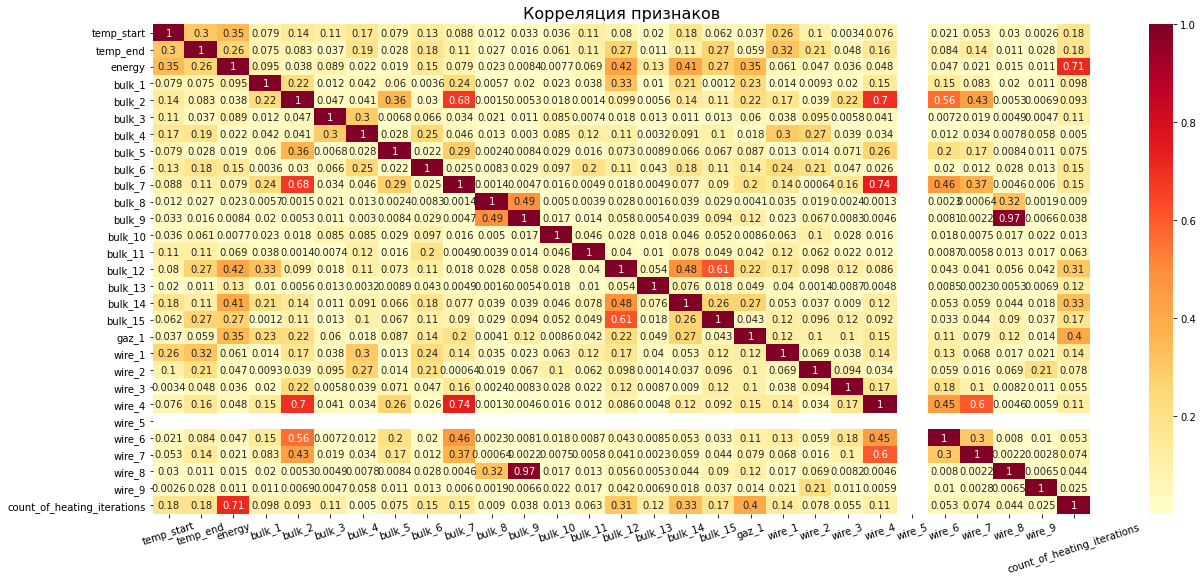

In [57]:
# Проверим корелляцию признаков

plt.figure(figsize=(21, 9))
fig = sns.heatmap(data_final.corr().abs(), cmap='YlOrRd', annot=True)
plt.title('Корреляция признаков', fontsize=16)
plt.setp(fig.get_xticklabels(), rotation=18)
plt.show()

Имеется корреляция некоторых признаков, однако по моему мнению она носит производственный характер (к примеру, зависимость присадок друг от друга объясняется технологическими особенностями приготовления нужного химического состава стали). Исходя из  этих соображений удалять или как-то изменять признаки считаю нецелесообразным.

Имеем полностью пустой столбец с признаком wire_5, однако если его удалить, то мы получим модель, так скажем, работующую не во всех диапазонах входящих в неё факторов. Т.е. по метрикам модель будет хорошая. А вот по бизнесу - не совсем применимая. Ведь входящий состав стали вполне может потребовать добавки именно этой присадки..

In [58]:
# Выделим целевой признак
features = data_final.drop('temp_end', axis=1)
target = data_final['temp_end']

# Разделим на тренировочную и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=RANDOM_STATE)

Создадим пустой Датафрем для записи результатов

In [59]:
data_analys = pd.DataFrame(columns = ['MAE'], 
                           index=['Lasso', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor'])

### Линейные модели

In [60]:
# Стандартизируем данные
# Обучаем StandartScaler на обучающей выборке

scaler = StandardScaler()
scaler.fit(features_train)

# Преобразуем обучающий и тестовый наборы данных

features_train_scaler = scaler.transform(features_train)
features_test_scaler = scaler.transform(features_test)

In [62]:
%%time
# LassoCV

model_lasso = LassoCV()

result = (cross_val_score(model_lasso, 
                             features_train_scaler, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
data_analys.loc['Lasso', 'MAE'] = result 
print(f'Лучшее значение MAE на тренировочной выборке: {result:.2f}')

Лучшее значение MAE на тренировочной выборке: 6.64
CPU times: user 1.57 s, sys: 1.79 s, total: 3.36 s
Wall time: 3.32 s


### RandomForestRegressor

In [63]:
%%time

model_rfr = RandomForestRegressor()
params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 4, 8],
    'bootstrap': [True, False],
    'random_state': [RANDOM_STATE]
}
forest_grid = GridSearchCV(model_rfr, params, cv=cv_counts, scoring='neg_mean_absolute_error')
forest_grid.fit(features_train, target_train)
result = abs(forest_grid.best_score_)
data_analys.loc['RandomForestRegressor', 'MAE'] = result 

print(f'Лучшее значение MAE на тренировочной выборке: {result:.2f}')

Лучшее значение MAE на тренировочной выборке: 6.55
CPU times: user 1min 46s, sys: 335 ms, total: 1min 47s
Wall time: 1min 47s


### CatBoostRegressor

In [64]:
%%time

model_cbr = CatBoostRegressor(verbose=False, custom_metric='MAE')
params = {
    'loss_function':['MAE'],
    'depth': [5],#[5, 8, 10],
    'learning_rate': [0.05],#[0.01, 0.05, 0.1],
    'n_estimators': [500],#[100, 300, 500],
    'random_state': [RANDOM_STATE]
}
cat_grid = GridSearchCV(model_cbr, params, cv=cv_counts, scoring='neg_mean_absolute_error', verbose=False)
cat_grid.fit(features_train, target_train)
# train_predictions = cat_grid.predict(features_train)
# result = mae(target_train, train_predictions)
# print(f'Лучшее значение MAE на тренировочной выборке: {result:.2f}')

cat_grid.best_score = abs(cat_grid.best_score_)
data_analys.loc['CatBoostRegressor', 'MAE'] = cat_grid.best_score 

print(f'Лучшее значение MAE на тренировочной выборке: {cat_grid.best_score:.2f}')

Лучшее значение MAE на тренировочной выборке: 6.45
CPU times: user 6.14 s, sys: 279 ms, total: 6.42 s
Wall time: 12.7 s


In [65]:
print("\n Лучшие подобранные параметры CatBoostRegressor:\n",cat_grid.best_params_)


 Лучшие подобранные параметры CatBoostRegressor:
 {'depth': 5, 'learning_rate': 0.05, 'loss_function': 'MAE', 'n_estimators': 500, 'random_state': 190623}


### LGBMRegressor

In [ ]:
%%time

model_lgbmr = LGBMRegressor()
params = {
    'metric': ['mae'],
    'max_depth': [5],#[5, 8, 10],
    'num_leaves': [50],# [10, 50, 100],
    'learning_rate': [0.01],# [0.001, 0.01, 0.03, 0.05],
    'random_state': [RANDOM_STATE],
}
lgbm_grid = GridSearchCV(model_lgbmr, params, cv=cv_counts, scoring='neg_mean_absolute_error', verbose=False)
lgbm_grid.fit(features_train, target_train)
train_predictions = lgbm_grid.predict(features_train)
# result = mae(target_train, train_predictions)
# print(f'Лучшее значение MAE на тренировочной выборке: {result:.2f}')

lgbm_grid.best_score = abs(lgbm_grid.best_score_)
data_analys.loc['LGBMRegressor', 'MAE'] = lgbm_grid.best_score 

print(f'Лучшее значение MAE на тренировочной выборке: {lgbm_grid.best_score:.2f}')

Определим лучшую модель

In [ ]:
data_analys = data_analys.astype(float)
data_analys.style.highlight_min(color="yellow")

По результатам исследования лучшей моделью признается модель CatBoostRegressor, ее мы и отправляем на тестирование

## Тестирование лучшей модели

In [ ]:
model = CatBoostRegressor(depth=5,
                          learning_rate=0.05,
                          loss_function='MAE',
                          n_estimators=500,
                          random_state=RANDOM_STATE,
                          verbose = False
)

model.fit(features_train, target_train)
predictions = model.predict(features_test)
result = mae(target_test, predictions)
print(f'Значение MAE на тестовой выборке: {result:.2f}')

plot_data = {
    'features': features_test.columns,
    'feature_importances': model.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(18, 9))
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
plt.title('Важность признаков для CatBoostRegressor', fontsize=14)
plt.xlabel('Критерий важности')
plt.ylabel('Названия признаков')
plt.show()

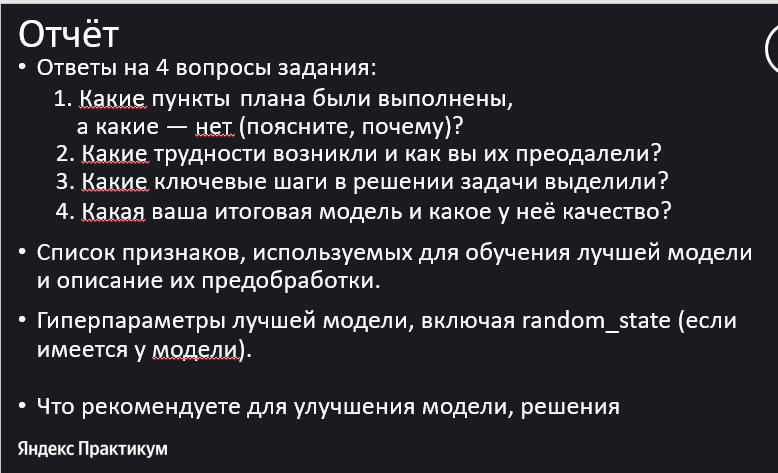

## Отчет по решению

### Какие пункты плана были выполнены, а какие — нет. Почему?
В процессе исследования были выполнены все намеченные пункты плана.
+ Проведена предобработка данных: изменили типы данных; обработали пропущенные и аномальные данные; созданы новые признаки и удалены признаки, не влияющие на целевой показатель.
+ Подготовили данные для обучения моделей. Составили сводный датасет для обучения моделей.
+ Обучили регрессионные модели: линейную регрессию, алгоритм случайного леса, CatBoostRegressor, LGBMRegressor.
+ Оценили эффективность выбранной модели на тестовой выборке.
+ Проанализировали важность факторов у модели-победителя.

### Какие трудности возникли и как вы их преодолели?
В процессе исследования обнаружились некоторые недостатки исходных данных, а также мультиколлинеарность — наличие сильной корреляции между некоторыми признаками. Недостатки исходных данных были исправлены в процессе стандартной предобработки данных: удалены явно аномальные значения, а также проведен анализ технологии производства и принято решение не учитывать температуру ниже температуры плавления стали. Мультиколлинеарность негативно влияет на модели машинного обучения. Так, например, для линейных моделей она может приводить к неустойчивости коэффициентов. Для исключения влияния мультиколлинеарности для линейной регрессии мы использовали метод регрессии “лассо” (LASSO, Least Absolute Shrinkage and Selection Operator).
Данный метод заключается во введении дополнительного слагаемого регуляризации в функционал оптимизации модели, что часто позволяет получать более устойчивое решение. 

### Какие ключевые шаги в решении задачи вы выделили?
Ключевыми шагами в решении поставленной задачи являлись:
1. Уточнение задачи, поставленной бизнесом. Изучение технологии производства, поиск и обоснование подходов к решению задачи. В качестве иллюстрации - удаление из исходных данных показателей температуры ниже температуры плавления стали.
2. Непосредственно подготвка данных к исследованию.
3. Поиск и тестирование подходящей для выполнения задачи модели.

### Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?
1. Целевым признаком является конечная температура.
2. Важнейшими признаками определили:
+ начальная температура расплава
+ общая потраченная мощность на нагрев
+ количество циклов нагрева расплава
+ количество присадок.


Предобработка признаков свелась к удалению аномалий, суммированию циклов нагрева и количества присадок по каждой партии.
Кроме того, создали новый признак в виде общей затраченной энергии.

### Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?
По результатам исследования лучшей моделью признается модель CatBoostRegressor, ее мы и отправили на тестирование.

Лучшие подобранные параметры CatBoostRegressor:

{'depth': 5, 'learning_rate': 0.05, 'loss_function': 'MAE', 'n_estimators': 500, 'random_state': 190623}

Значение MAE лучшей модели на тестовой выборке: 6.38.

Таким образом, наша модель ошибается в среднем на чуть больше чем 6 градусов. По моему мнению, точность вполне себе приличная.

### Что рекомендуете для улучшения модели, решения
Для улучшения показателей существует два подхода - интенсивный и экстенсивный.\
Экстенсивность хозяйства проявляется в увеличении используемых в производстве ресурсов, привлечении дополнительной рабочей силы. То есть источником развития такого типа можно назвать повышение объема факторов производства. Мы можем увеличивать количество датчиков, измерять иные параметры расплавах в разные временные промежутки и т.д. Среди положительных сторон можно отметить рост производственных показателей. Но есть и недостатки у данного пути развития
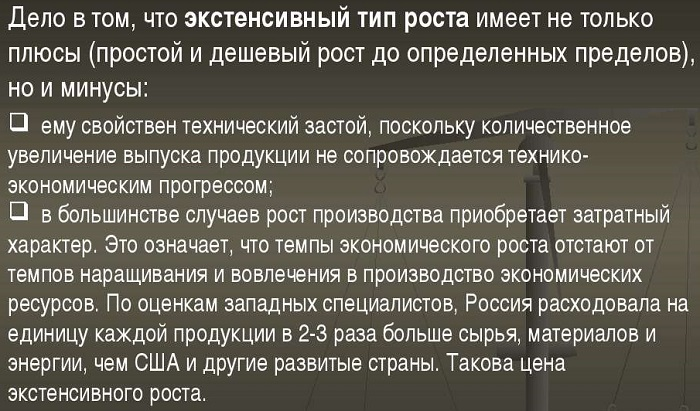

Факторами интенсификации производства являются: повышение квалификации кадров; внедрение достижений науки; использование современного оборудования; автоматизация процесса; использование технологий, экономящих ресурсы. Т.е. мы можем внедрять новые системы слежения за температурой, включая новые датчики, системы управления ими и т.д. Возможна перенастройка всего производственного процесса, исходя из полученных промежуточных данных.. Возможно контроль промежуточной температуры и снижение температуры расплава до таких величин, которые не влияют на техпроцесс, но позволяют существенно экономить ресурсы. Возможно предварительная подготовка поступающего сырья, его более тщательная сортировка и т.д.

Ну и последнее. При презентации результатов заказчику необходимо выяснить, достаточная ли точность полученной модели? Ведь 6 градусов из 1400 - это 4 процента. Вполне возможно, что точность достаточна, и дальнейшие шаги по улучшению энергоэффективности необходимо проводить в других областях техпроцесса.